In [1]:
import sys
sys.path.insert(0, "../../python")

from propagation import laser
from ionization import ionization
from ionization import adk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import integrate
from scipy.optimize import curve_fit

12.2756554256


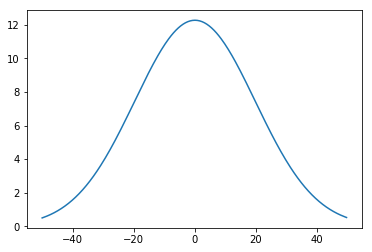

In [2]:
# Testing to see if ionization of the plasma effects light propagation
# Setup the transverse grid
Nx = 2**10
X = 8000
x = np.linspace(-X/2, X/2, Nx, False)
Ny = 2**8
Y = X
y = np.linspace(-Y/2, Y/2, Ny, False)
# Setup longitudinal grid
Nz = 2**8
Z = 1e6
z = np.linspace(0, Z, Nz)
# Setup time discretization
Nt = 2**8
T = 100
t = np.linspace(-T/2, T/2, Nt, False)
dt = T/(Nt-1)

# Initial transverse Gaussian pulse
w0 = 2e3
E0 = np.exp(-(np.reshape(x, (Nx, 1))**2 + np.reshape(y, (1, Ny))**2) / w0**2)

# Axicon lens
alpha = np.radians(0.5)
T0 = np.exp(-1j*np.pi*alpha*np.sqrt(np.reshape(x, (Nx, 1))**2 + np.reshape(y, (1, Ny))**2))

# Initial field
Ei = E0 * T0

# Initial index of refraction
n0 = 1.0 + 6.67e-8
nih = np.zeros((Nx, Ny, Nz))

# Initial plasma density
nmax = 1 # in 1e17 cm^-3
n = np.zeros ((Nx, Ny, Nz))

# Temporal pulse shape
tau = 35
lam = 0.8
f = 0.3/lam
omega = 2*np.pi*f
Et = ionization.gaussian_envelope(0.2, t, tau).real
# Make sure everything looks right
print(ionization.field_from_intensity(0.2))
plt.plot(t, Et)
plt.show()

# Storagr array for E field plots and ionization fraction
Eplot = np.zeros((Nt, Nz, Nx))
nplot = np.zeros((Nt, Nx, Nz))

In [3]:
for i in range(Nt):
    E = Ei * Et[i]
    # Propogate beam through plasma
    Ef = laser.beam_prop2(E, nih, x, y, z, 0.8, n0)
    Eplot[i, :, :] = abs(Ef[:, :, int(Ny/2)])
    # calculate ionization rate from beam
    rate = adk.rate_linear(13.5984, abs(Ef), 1)
    rate = np.moveaxis(rate, 0, -1)
    # plasma density = Un-ionized gas density * fraction ionized + ionized gas density
    n = (nmax - n)*(1 - np.exp(-rate * dt)) + n
    nplot[i, :, :] = n[:, int(Ny/2), :]
    # Calculate new index of refraction
    nih = 0.5*(-6.67e-8*n - 5.73e-5*n)
    print('Completed time slice ', i+1, ' of ', Nt)

Completed time slice  1  of  256
Completed time slice  2  of  256
Completed time slice  3  of  256
Completed time slice  4  of  256
Completed time slice  5  of  256
Completed time slice  6  of  256
Completed time slice  7  of  256
Completed time slice  8  of  256
Completed time slice  9  of  256
Completed time slice  10  of  256
Completed time slice  11  of  256
Completed time slice  12  of  256
Completed time slice  13  of  256
Completed time slice  14  of  256
Completed time slice  15  of  256
Completed time slice  16  of  256
Completed time slice  17  of  256
Completed time slice  18  of  256
Completed time slice  19  of  256
Completed time slice  20  of  256
Completed time slice  21  of  256
Completed time slice  22  of  256
Completed time slice  23  of  256
Completed time slice  24  of  256
Completed time slice  25  of  256
Completed time slice  26  of  256
Completed time slice  27  of  256
Completed time slice  28  of  256
Completed time slice  29  of  256
Completed time slice  3

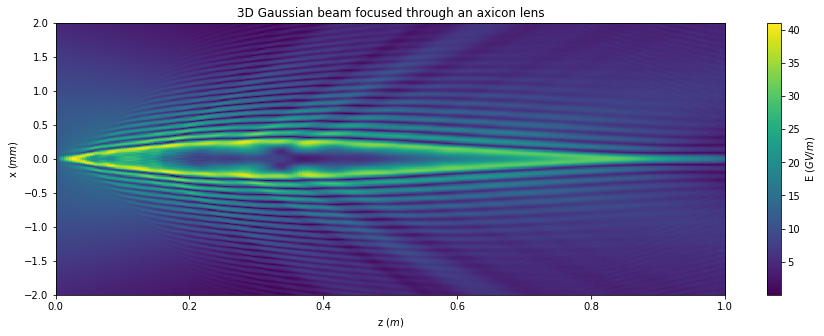

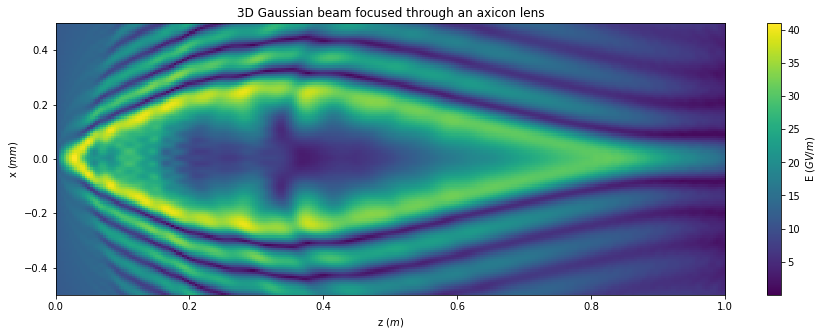

In [7]:
ind = 128

plt.figure(figsize=(15, 5))
plt.imshow(np.flipud(np.transpose(Eplot[ind, :, :])), aspect='auto', extent=[0, Z/1e6, -X/2e3, X/2e3])
cb = plt.colorbar()
cb.set_label(r'E ($GV/m$)')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'x ($mm$)')
plt.title('3D Gaussian beam focused through an axicon lens')
plt.xlim([0, Z/1e6])
plt.ylim([-2, 2])
plt.show()

plt.figure(figsize=(15, 5))
plt.imshow(np.flipud(np.transpose(Eplot[ind, :, :])), aspect='auto', extent=[0, Z/1e6, -X/2e3, X/2e3])
cb = plt.colorbar()
cb.set_label(r'E ($GV/m$)')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'x ($mm$)')
plt.title('3D Gaussian beam focused through an axicon lens')
plt.xlim([0, Z/1e6])
plt.ylim([-0.5, 0.5])
plt.show()

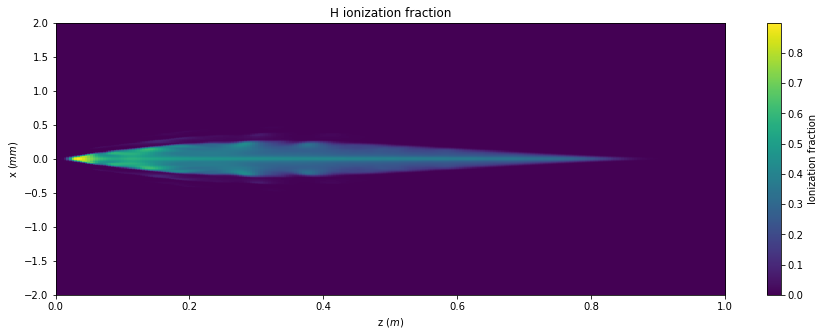

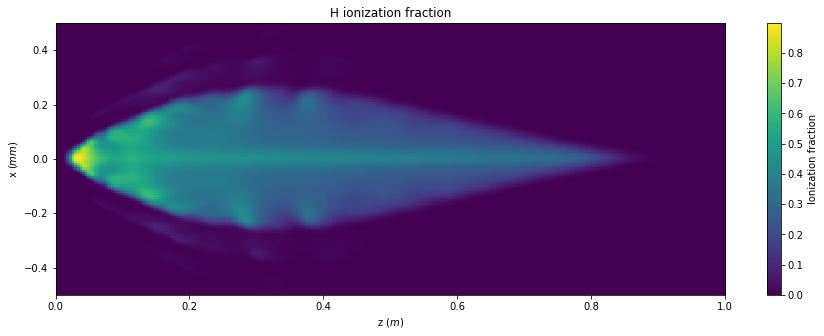

In [8]:
ind = 128

plt.figure(figsize=(15, 5))
plt.imshow(np.flipud(nplot[ind, :, :]), aspect='auto', extent=[0, Z/1e6, -X/2e3, X/2e3,])
cb = plt.colorbar()
cb.set_label(r'Ionization fraction')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'x ($mm$)')
plt.title('H ionization fraction')
plt.xlim([0, Z/1e6])
plt.ylim([-2, 2])
plt.show()

plt.figure(figsize=(15, 5))
plt.imshow(np.flipud(nplot[ind, :, :]), aspect='auto', extent=[0, Z/1e6, -X/2e3, X/2e3])
cb = plt.colorbar()
cb.set_label(r'Ionization fraction')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'x ($mm$)')
plt.title('H ionization fraction')
plt.xlim([0, Z/1e6])
plt.ylim([-0.5, 0.5])
plt.show()

In [10]:
# Write simulation data to file
np.save('electricField', Eplot)
np.save('ionizationFrac', nplot)
np.save('inputField', Ei)
np.save('inputPulse', Et)